In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
df = pd.read_csv('/content/drive/MyDrive/spam.csv',delimiter=',',encoding='latin-1')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

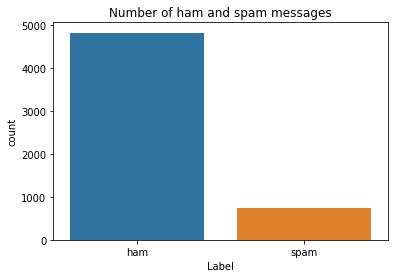

In [8]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [9]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [11]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)


In [12]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [13]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [14]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [15]:
data=df.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [17]:
data["Message Length"]=data["Message"].apply(len)

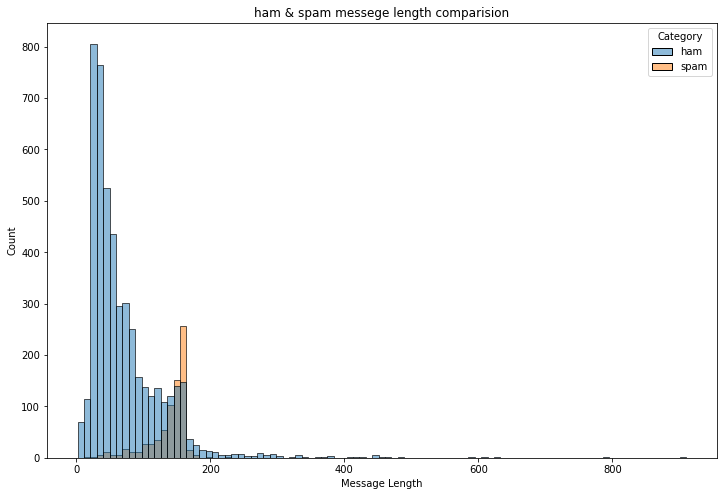

In [18]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [19]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

Ham Messege Length Description:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: Message Length, dtype: float64
************************************
Spam Message Length Description:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: Message Length, dtype: float64


In [20]:
data.describe(include="all")

,Category,Message,Message Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


In [21]:
data["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

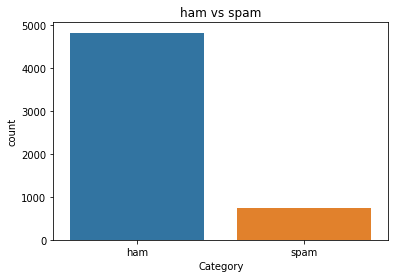

In [22]:
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
plt.show()


In [23]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


In [24]:
#compute the length of majority & minority class
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=data.loc[undersampled_indices]

#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

#drop the older index
df=df.drop(
    columns=["index"],
)

In [26]:
df.shape

(1494, 3)

In [25]:
df["Category"].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

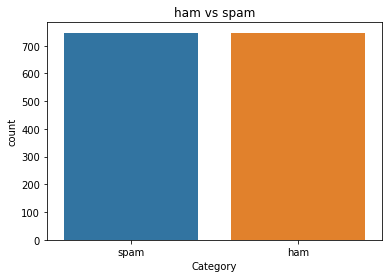

In [27]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

In [28]:
df.head()

,Category,Message,Message Length
0,spam,FREE GAME. Get Rayman Golf 4 FREE from the O2 ...,153
1,ham,"Goodmorning, Today i am late for &lt;#&gt; min.",48
2,ham,Oh ic. I thought you meant mary jane.,37
3,ham,Probably money worries. Things are coming due ...,126
4,ham,I'm home. Ard wat time will u reach?,36


In [29]:
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [30]:
df.head()

,Category,Message,Message Length,Label
0,spam,FREE GAME. Get Rayman Golf 4 FREE from the O2 ...,153,1
1,ham,"Goodmorning, Today i am late for &lt;#&gt; min.",48,0
2,ham,Oh ic. I thought you meant mary jane.,37,0
3,ham,Probably money worries. Things are coming due ...,126,0
4,ham,I'm home. Ard wat time will u reach?,36,0


In [31]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()

In [32]:
#declare empty list to store tokenized message
corpus=[]

#iterate through the df["Message"]
for message in df["Message"]:
    
    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)
    
    #convert every letters to its lowercase
    message=message.lower()
    
    #split the word into individual word list
    message=message.split()
    
   

In [33]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]

In [34]:
df["Message Length"].describe()

count    1494.000000
mean      103.929050
std        54.880217
min         3.000000
25%        50.000000
50%       117.000000
75%       153.000000
max       450.000000
Name: Message Length, dtype: float64

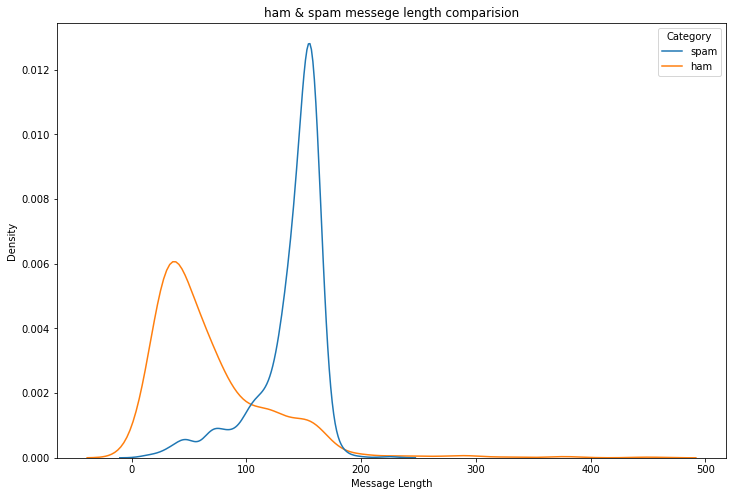

In [35]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

In [37]:
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Label"]

In [38]:
df_final=pd.concat([extract_features,target],axis=1)

In [39]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [40]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_trainval,X_test,y_trainval,y_test=train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.15
)

In [43]:
X_train,X_val,y_train,y_val=train_test_split(
    X_trainval,
    y_trainval,
    random_state=42,
    test_size=0.15
)

In [44]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 